# Quick Overview  
We use <a href='https://brickschema.org/'>Brick</a> and <a href='https://mortardata.org/intro.html'>Mortar</a> to evalute long-term thermal comfort across 25 buildings. All analytic graphs and tables in our ASHRAE paper are reproducible here. You don't need to do anything except running the cell by sequence, but feel free to try something different. Have fun!

v0.7; November 2021

## Connect to Mortar API

In [1]:
import pymortar
# build a client to Mortar frontend server
client = pymortar.Client("https://beta-api.mortardata.org")

In [2]:
# check pymortar version == 2.0.5
!pip show pymortar

Name: pymortar
Version: 2.0.5
Summary: 
Home-page: None
Author: Gabe Fierro
Author-email: gtfierro@cs.berkeley.edu
License: None
Location: /opt/anaconda3/lib/python3.8/site-packages
Requires: pyarrow, requests, brickschema, python-snappy, googleapis-common-protos, toml, pandas, rdflib
Required-by: 


## Write a Brick metadata model query

In [48]:
# the query could be just zone air temperature sensor or with other related entities
query = """SELECT ?sensor ?zone ?vav ?room ?floor ?ahu WHERE {{
    ?sensor a brick:Zone_Air_Temperature_Sensor .
    ?sensor brick:isPointOf ?vav .
    ?vav brick:feeds ?zone .
    ?zone a brick:HVAC_Zone .
    ?zone brick:hasPart ?room .
    ?room a brick:Room .
    ?room brick:isPartOf ?floor .
    ?floor a brick:Floor .
    ?ahu a brick:AHU .
    ?ahu brick:feeds ?vav .
}}"""

In [49]:
# get which sites return results for the query above
qualify_resp = client.qualify([query])
print("Mortar has {0} qualifed sites".format(len(qualify_resp.sites)))
print(qualify_resp.sites)

Mortar has 25 qualifed sites
['artx', 'bwfp', 'chem', 'chemx', 'crus', 'dh', 'fdpd', 'gbsf', 'gha_ics', 'giedt', 'hart', 'hwc', 'mann', 'msb', 'music', 'roes', 'stor', 'thur', 'veih', 'vm3a', 'vmep', 'vmif', 'vmth', 'well', 'wsrc']


## Analysis - Discomfort Indices comparasion

In [53]:
# display all content in a pd df column and discard warning info
pd.set_option('display.max_colwidth', None)
pd.set_option('mode.chained_assignment', None)

In [51]:
# get the brick metadata of the query sensors across all sites, except 'vmif'
metadata_all = client.sparql(query, sites=qualify_resp.sites)

In [57]:
from range_outlier import *
from daily_range_outlier import *
import re
# assign values to index function input variables
md = 'tbd'
sd = '2016-1-1'
ed = '2016-12-31'
sh = 9
eh = 17
sl = 71.6
su = 80.6
wl = 66.2
wu = 77.0
th = 3

res = []
for idxi, row in metadata_all.iterrows():
    res_row = {}
    md = row.sensor
    ro_p = range_outlier(md, sd, ed, sh, eh, sl, su, wl, wu)
    dro_p = daily_range_outlier(md, sd, ed, sh, eh, th)
    for k in metadata_all.columns:
        res_row[k] = 'Zon_Air_Temp' if k == 'sensor' else re.split('[#]', row[k])[-1]
    res_row['ro_index'] = ro_p
    res_row['dro_index'] = dro_p
    res += [res_row]
    # print result
    print(res_row['site'], ro_p, dro_p)
# store the result list as a dataframe
res_df = pd.DataFrame(res)

artx 0.03 0.01
artx 0.06 0.0
artx 0.04 0.0
artx 0.17 0.01
artx 0.03 0.0
artx 0.05 0.0
artx 0.03 0.0
artx 0.03 0.01
bwfp 0.85 0.02
bwfp 0.83 0.03
bwfp 0.97 0.02
bwfp 0.01 0.0
bwfp 0.49 0.0
bwfp 0.99 0.01
bwfp 0.16 0.01
bwfp 0.38 0.02
bwfp 0.37 0.02
bwfp 0.33 0.0
bwfp 0.69 0.03
bwfp 0.1 0.01
bwfp 0.01 0.0
bwfp 0.01 0.01
bwfp 0.5 0.0
bwfp 0.98 0.02
bwfp 0.15 0.01
bwfp 1.0 0.02
bwfp 0.0 0.01
bwfp 0.01 0.0
bwfp 1.0 0.01
bwfp 0.94 0.03
bwfp 0.02 0.01
bwfp 0.32 0.0
bwfp 1.0 0.02
bwfp 0.95 0.03
bwfp 1.0 0.03
bwfp 1.0 0.03
bwfp 0.51 0.0
bwfp 0.0 0.01
bwfp 1.0 0.03
bwfp 0.88 0.03
bwfp 0.99 0.01
bwfp 0.86 0.03
bwfp 0.03 0.0
bwfp 0.82 0.03
bwfp 1.0 0.03
bwfp 0.93 0.03
bwfp 0.94 0.03
bwfp 1.0 0.03
bwfp 0.57 0.02
bwfp 0.99 0.03
bwfp 1.0 0.03
bwfp 0.48 0.02
bwfp 0.07 0.02
bwfp 0.97 0.01
bwfp 0.99 0.01
bwfp 0.97 0.01
bwfp 0.89 0.03
bwfp 1.0 0.02
bwfp 0.98 0.02
bwfp 1.0 0.03
bwfp 0.98 0.03
bwfp 0.91 0.03
bwfp 1.0 0.03
bwfp 0.0 0.01
bwfp 0.96 0.02
bwfp 0.49 0.0
bwfp 1.0 0.03
bwfp 0.11 0.01
bwfp 1.0 0.03

In [58]:
res_df

,sensor,zone,vav,room,floor,ahu,site,ro_index,dro_index
0,Zon_Air_Temp,RM103,VAVRM103,RM103_room,floor1,AHU02,artx,0.03,0.01
1,Zon_Air_Temp,RM107B,VAVRM107B,RM107B_room,floor1,AHU01,artx,0.06,0.00
2,Zon_Air_Temp,RM112,VAVRM112,RM112_room,floor1,AHU02,artx,0.04,0.00
3,Zon_Air_Temp,RM110,VAVRM110,RM110_room,floor1,AHU02,artx,0.17,0.01
4,Zon_Air_Temp,RM115,VAVRM115,RM115_room,floor1,AHU01,artx,0.03,0.00
...,...,...,...,...,...,...,...,...,...
2106,Zon_Air_Temp,RM2100_MIX,VAVRM2100_MIX,RM2100_MIX_room,floor2,AHU03,wsrc,0.14,0.03
2107,Zon_Air_Temp,RM2110,VAVRM2110,RM2110_room,floor2,AHU03,wsrc,0.18,0.00
2108,Zon_Air_Temp,RM2204_MIX,VAVRM2204_MIX,RM2204_MIX_room,floor2,AHU03,wsrc,0.11,0.00
2109,Zon_Air_Temp,RM2202A_MIX,VAVRM2202A_MIX,RM2202A_MIX_room,floor2,AHU03,wsrc,0.01,0.00


<AxesSubplot:xlabel='ro_index', ylabel='dro_index'>

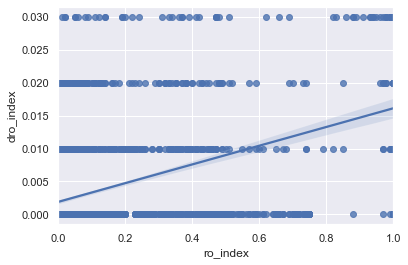

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(color_codes=True)
sns.regplot(x="ro_index", y="dro_index", data=res_df)

<AxesSubplot:xlabel='ro_index', ylabel='dro_index'>

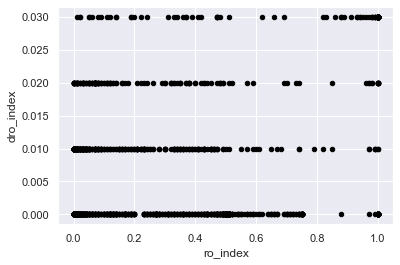

In [67]:
res_df.plot.scatter(x="ro_index", y="dro_index", c='Black')

In [ ]:
}